# Going Modular


## 0. Main Concept
The main concept of this section is: turn useful notebook code cells into reusable Python files.


By the end of this section we want to have two things:

* The ability to train the model we built in notebook 04 (Food Vision Mini) with one line of code on the command line: python train.py.
* A directory structure of reusable Python scripts, such as:

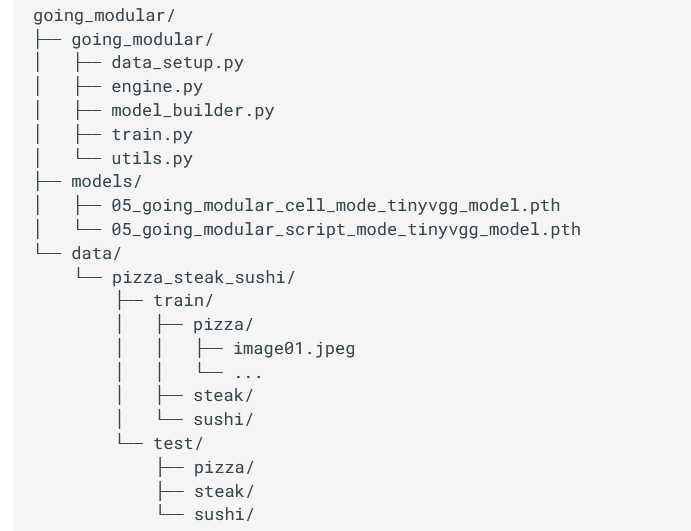



## 1. Get Data
Main purpose of this notebook will be to download the data


In [2]:
import os
import requests
import zipfile
from pathlib import Path

# Setup path to data folder

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# now we check if our folder is already created

if image_path.is_dir():
    print(f"directory exists already.")
else:
    print(f"Did not find the directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza,steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...") 
    zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "pizza_steak_sushi.zip")

directory exists already.
Unzipping pizza, steak, sushi data...


## 2. Create datasets and dataloaders (`data_setup.py`)

In [6]:
%%writefile going_modular/data_setup.py

import os

from torchvision import datasets,transforms
from torch.utils.data import DataLoader

NUM_WORKERS = 2

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS
):
    # split in train and testing dataset
    train_data = datasets.ImageFolder(train_dir, transform = transform)
    test_data = datasets.ImageFolder(test_dir, transform = transform)

    #get class names for labeling conversion
    class_names = train_data.classes

    train_dataloader = DataLoader(
        train_data,
        batch_size = batch_size,
        shuffle = True,
        num_workers = num_workers,
        pin_memory = True
    )

    test_dataloader = DataLoader(
        test_data,
        batch_size = batch_size,
        shuffle = False,
        num_workers = num_workers,
        pin_memory = True
    )

    return train_dataloader, test_dataloader, class_names



Writing going_modular/data_setup.py


FileNotFoundError: [Errno 2] No such file or directory: 'going_modular/data_setup.py'

## 3. Making a model (`model_builder.py`)

In [7]:
%%writefile going_modular/model_builder.py


import torch
from torch import nn

class TinyVGG(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels = input_shape,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 0),
            nn.ReLU(),
            nn.Conv2d(
                in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size = 2,
                stride = 2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size = 3, padding = 0),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size = 3, padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features = hidden_units*13*13,
                out_featurs = output_shape)
        )


    def forward (self, x : torch.tensor):
        
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

Writing going_modular/model_builder.py


FileNotFoundError: [Errno 2] No such file or directory: 'going_modular/model_builder.py'

## 4. Create train test step + combine them

In [8]:
%%writefile going_modular/engine.py

import torch 

from tqdm.auto import tqdm
from typing import Dict, List, Tuple


def train_step(
    model : torch.nn.Module,
    dataloader : torch.utils.data.DataLoader,
    loss_fn : torch.nn.Module,
    optimizer : torch.optim.Optimizer,
    device : torch.device
) -> Tuple[float,float]: 

    model.train()

    train_loss , train_acc = 0, 0

    for batch, (X,y) in enumerate(dataloader):

        X,y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)

        train_acc = (y_pred_class == y).sum().item()/len(y_pred)

    
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc


def test_step(
    model : torch.nn.Module,
    dataloader : torch.utils.data.DataLoader,
    loss_fn : torch.nn.Module,
    device : torch.device
)-> Tuple[float,float] :

    model.eval()

    test_loss , test_acc = 0, 0

    with torch.inference_mode():
        for batch , (X,y) in enumerate(dataloader):

            X , y = X.to(device) , y.to(device)

            test_pred = model(X)

            loss = loss_fn(test_pred, y)

            test_loss += loss.item()

            test_pred_label = test_pred.argmax(dim = 1)
            test_acc += (test_pred_label == y).sum().item()/len(test_pred_label)


        test_loss /= len(dataloader)
        test_acc /= len(dataloader)


def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device
) -> Dict[str, List]:

    results = {
        "train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]
        }


    for epoch in tqdm(range(epochs)):

        train_loss , train_acc = train_step(model,train_dataloader, loss_fn,optimizer,device)
        test_loss , test_acc = test_step(model, test_dataloader, loss_fn,device)

        # print whats happening 
        # Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results





Writing going_modular/engine.py


FileNotFoundError: [Errno 2] No such file or directory: 'going_modular/engine.py'

## 5. Creating a function to save a model

In [9]:
%%writefile going_modular/utils.py
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

Writing going_modular/utils.py


FileNotFoundError: [Errno 2] No such file or directory: 'going_modular/utils.py'

 6. Train, evaluate and save the model (train.py)

To create train.py we'll go through the following steps:

 *   Import the various dependencies, namely torch, os, torchvision.transforms and all of the scripts from the going_modular directory, data_setup, engine, model_builder, utils.
* **Note: Since train.py will be inside the going_modular directory, we can import the other modules via import ... rather than from going_modular import ....**
* Setup various hyperparameters such as batch size, number of epochs, learning rate and number of hidden units (these could be set in the future via Python's argparse).
* Setup the training and test directories.
* Setup device-agnostic code.
* Create the necessary data transforms.
* Create the DataLoaders using data_setup.py.
* Create the model using model_builder.py.
*  Setup the loss function and optimizer.
*   Train the model using engine.py.
*    Save the model using utils.py.

**Have to put this in def main else give process issue**


In [ ]:
%%writefile going_modular/train.py
"""
Trains a PyTorch image classification model using device-agnostic code.
"""

import os
import torch
import data_setup, engine, model_builder, utils

from torchvision import transforms

def main():
    # Setup hyperparameters
    NUM_EPOCHS = 5
    BATCH_SIZE = 32
    HIDDEN_UNITS = 10
    LEARNING_RATE = 0.001

    # Setup directories
    train_dir = "data/pizza_steak_sushi/train"
    test_dir = "data/pizza_steak_sushi/test"

    # Setup target device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Create transforms
    data_transform = transforms.Compose([
      transforms.Resize((64, 64)),
      transforms.ToTensor()
    ])

    # Create DataLoaders with help from data_setup.py
    train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
        train_dir=train_dir,
        test_dir=test_dir,
        transform=data_transform,
        batch_size=BATCH_SIZE
    )

    # Create model with help from model_builder.py
    model = model_builder.TinyVGG(
        input_shape=3,
        hidden_units=HIDDEN_UNITS,
        output_shape=len(class_names)
    ).to(device)

    # Set loss and optimizer
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=LEARNING_RATE)

    # Start training with help from engine.py
    engine.train(model=model,
                 train_dataloader=train_dataloader,
                 test_dataloader=test_dataloader,
                 loss_fn=loss_fn,
                 optimizer=optimizer,
                 epochs=NUM_EPOCHS,
                 device=device)

    # Save the model with help from utils.py
    utils.save_model(model=model,
                     target_dir="models",
                     model_name="05_going_modular_script_mode_tinyvgg_model.pth")


if __name__ == '__main__':
    main()